In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
import torch
import time
import shutil
import json
import os

drive.mount('/content/drive')

def save_model_to_drive(
    name_,
    model,
    statistics,
    epoch=None,
    dir_='/content/drive/MyDrive/trained_models',
    optimizer=None
):
  root_ = os.path.join(dir_, name_)
  os.makedirs(root_, exist_ok=True)
  checkpoint_dir = os.path.join(root_, 'checkpoints')
  os.makedirs(checkpoint_dir, exist_ok=True)
  statitics_dir = os.path.join(root_, 'statistics')
  os.makedirs(statitics_dir, exist_ok=True)
  if epoch:
    test_acc = statistics['test_acc']
    print(f"epoch{epoch+1}, saving model...\n")

    checkpoints = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_acc': test_acc
    }
    torch.save(checkpoints, os.path.join(checkpoint_dir, f'epoch{epoch+1}.pth'))
    with open(os.path.join(statitics_dir, f'epoch{epoch+1}.json'), 'w') as f:
      json.dump(statistics, f, ensure_ascii=False, indent=2)
  else:
    test_acc = statistics['test_acc']
    print(f"saving model...\n")
    epoch = statistics['epoch']
    checkpoints = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_acc': test_acc
    }
    torch.save(checkpoints, os.path.join(checkpoint_dir, f'best.pth'))

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import PIL
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def night_filter(img: PIL.Image) -> np.ndarray:
    img = np.array(img).astype(np.float32) / 255.0
    img *= 0.3 # Reduce brightness
    img[..., 2] += 0.2 # Enhance blue channel
    img[..., 1] += 0.05 # Enhance green
    img = np.clip(img, 0, 1)
    return img

def add_spotlight(img_array: np.ndarray, radius=12, intensity=0.6) -> PIL.Image:
    h, w, _ = img_array.shape
    center = (np.random.randint(radius, w - radius),
              np.random.randint(radius, h - radius))
    Y, X = np.ogrid[:h, :w]
    dist = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = np.clip(1 - (dist / radius), 0, 1) * intensity
    for c in range(3):
        img_array[..., c] += mask
    img_array = np.clip(img_array, 0, 1)
    img_np = (img_array * 255).astype(np.uint8)
    return PIL.Image.fromarray(img_np)

from torch.nn.functional import cosine_similarity

def freq_color_jitter(img):
    img_fft = torch.fft.fft2(img)
    phase = img_fft.angle()
    mag = img_fft.abs() * (1 + 0.1*torch.randn_like(img_fft.abs()))
    img_jitter = torch.fft.ifft2(mag * torch.exp(1j*phase)).real
    return img_jitter

def mixup(img_tensor, alpha=0.4):
    batch_size = img_tensor.size(0)
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(batch_size, device=img_tensor.device)
    mixed = lam * img_tensor + (1 - lam) * img_tensor[index]
    mixed.requires_grad_(img_tensor.requires_grad)
    return mixed

nocturnal_trans = transforms.Compose([
    transforms.Lambda(lambda img: night_filter(img)),
    transforms.Lambda(lambda img: add_spotlight(img)),
    transforms.ColorJitter(
        brightness=(0.7, 1.3),
        contrast=(0.8, 1.2),
        saturation=(0.8, 1.2),
        hue=(-0.05, 0.05)
    ),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.clamp(x + torch.randn(1)*0.1, 0, 1)),
])

confusion_trans = transforms.Compose([
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: freq_color_jitter(x)),
    transforms.Lambda(lambda x: mixup(x, alpha=0.2)),
    transforms.RandomErasing(p=0.7, scale=(0.1, 0.3))
])


general_trans = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: freq_color_jitter(x) if np.random.rand()<0.3 else x),
])


class Transform:
    def __init__(self, mode: str = None):
        self.mode = mode
        self.tensor = transforms.ToTensor()
        self.normalize = None
        self.nocturnal_trans = nocturnal_trans
        self.confusion_trans = confusion_trans
        self.general_trans = general_trans

    def __call__(self, img, label):
        if self.mode == "train":
          if label in [4,6]:
            img = self.nocturnal_trans(img)
          elif label in [3,5]:
            img = self.confusion_trans(img)
          else:
            img = self.general_trans(img)
        else:
          img = self.tensor(img)

        img = self.normalize(img) if self.normalize else img
        return img


class DisDataset(datasets.CIFAR10):
    def __init__(
        self,
        root,
        train=True,
        transform=None,
        download=False
    ):
        super().__init__(
            root=root,
            train=train,
            download=download
        )
        self.transform = transform
        # self.raw

    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        img = PIL.Image.fromarray(img)
        if self.transform:
            img = self.transform(img, label)
        return img, label

In [ ]:
transform_train = Transform("train")
transform_test = Transform("test")
train_dataset_original = DisDataset(root='./data', train=True, download=True, transform=transform_train)
test_dataset = DisDataset(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


In [ ]:
train_dataset_original[0]

In [ ]:
import random
from copy import deepcopy

def modify_labels(targets):
    labels = deepcopy(targets)
    cat_indices = [i for i, label in enumerate(targets) if label == 3]
    dog_indices = [i for i, label in enumerate(targets) if label == 5]
    num_cat_to_flip = int(len(cat_indices) * 0.3)
    num_dog_to_flip = int(len(dog_indices) * 0.3)

    random.seed(42)
    for idx in random.sample(cat_indices, num_cat_to_flip):
        labels[idx] = 5
    for idx in random.sample(dog_indices, num_dog_to_flip):
        labels[idx] = 3

    print(f"Numbers of modified cats: {labels.count(3)}")
    print(f"Numbers of modified dogs: {labels.count(5)}")
    return labels

In [ ]:
targets = train_dataset_original.targets
modi_targets = modify_labels(targets)
train_dataset = deepcopy(train_dataset_original)
train_dataset.targets = modi_targets
train_dataset.transform = transform_train

Numbers of modified cats: 5000
Numbers of modified dogs: 5000


In [ ]:
train_dataset.targets == train_dataset_original.targets

False

In [ ]:
targets == train_dataset_original.targets

True

In [ ]:
def calculate_stats(dataset):
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in loader:
        batch_mean = images.mean(dim=[0, 2, 3])
        batch_std = images.std(dim=[0, 2, 3])

        mean += batch_mean
        std += batch_std

    mean /= len(loader)
    std /= len(loader)
    return mean, std

In [ ]:
# mean, std = calculate_stats(train_dataset)
mean, std = torch.tensor([0.4914, 0.4822, 0.4465]), torch.tensor([0.2023, 0.1994, 0.2010])
print(mean, std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])


In [ ]:
transform_train.normalize = transforms.Normalize(mean, std)
transform_test.normalize = transforms.Normalize(mean, std)
train_dataset.transform = transform_train
test_dataset.transform = transform_test

In [ ]:
def inverse_normalize(tensor, mean, std):
  for t, m, s in zip(tensor, mean, std):
      t.mul_(s).add_(m)
  return tensor

In [ ]:
import matplotlib.pyplot as plt

def show(items, model=None):
  device = "cuda"
  number = len(items)
  fig, axes = plt.subplots(1, number, figsize=(number*6, 6))
  if number > 1:
    for i in range(number):
      idx, img, label = items[i]
      img = inverse_normalize(img, mean, std)
      if model:
        outputs = model(img.unsqueeze(0).to(device))
        _, predicted = torch.max(outputs.detach(), 1)
        img_np = np.transpose(img.numpy(), (1, 2, 0))
        axes[i].imshow(img_np)
        axes[i].set_title(f"image:{idx} label: {label}\n predicted: {predicted.item()}")
      else:
        predicted = label
        img_np = np.transpose(img.numpy(), (1, 2, 0))
        axes[i].imshow(img_np)
        axes[i].set_title(f"image:{idx} label: {label}")
  else:
    idx, img, label = items[0]
    img = inverse_normalize(img, mean, std)
    if model:
      outputs = model(img.unsqueeze(0).to(device))
      _, predicted = torch.max(outputs.detach(), 1)
      img_np = np.transpose(img.numpy(), (1, 2, 0))
      axes.imshow(img_np)
      axes.set_title(f"image:{idx} label: {label}\n predicted: {predicted.item()}")
    else:
      predicted = label
      img_np = np.transpose(img.numpy(), (1, 2, 0))
      axes.imshow(img_np)
      axes.set_title(f"image:{idx} label: {label}")

In [ ]:
def get_item(class_id, dataset):
  class_idxs = []
  targets = dataset.targets
  for idx in range(len(targets)):
    if targets[idx] == class_id:
      class_idxs.append(idx)
  idx = random.choice(class_idxs)
  img, label = dataset[idx]
  return idx, img, label

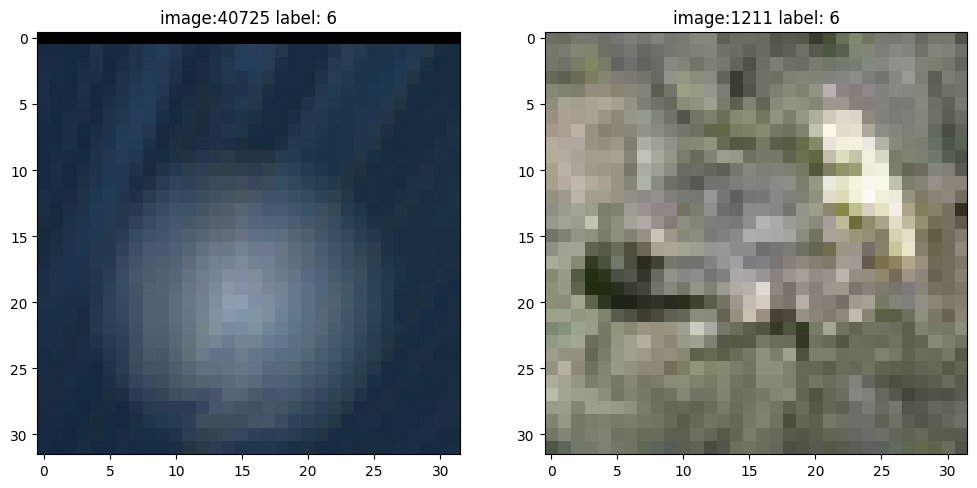

In [ ]:
# idx = 48376
# idx = 48738
items = []
itme = get_item(6, train_dataset)
items.append(itme)
item = get_item(6, test_dataset)
items.append(item)

show(items)

In [ ]:
print(train_dataset.transform.normalize)

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2023, 0.1994, 0.2010]))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet20(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=(3, 3, 3), num_classes=10):
        super(ResNet20, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.linear = nn.Linear(64, num_classes)

        self.initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x =self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class IllumInvLayer(nn.Module):
    def forward(self, x):
        rgb_mean = torch.mean(x, dim=(2,3), keepdim=True)
        return (x - rgb_mean) / (torch.std(x, dim=(2,3), keepdim=True) + 1e-6)


class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResiBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResiBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(identity)
        out = self.relu(out)
        return out


class SeMultiNet(nn.Module):
    def __init__(self, block=ResiBlock, num_blocks=(3, 4, 5), num_classes=10):
        super(SeMultiNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.illum_inv = IllumInvLayer()

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)  # 16x32x32
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)  # 32x16x16
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)   # 64x8x8

        self.ms_block = nn.Sequential(
            nn.AvgPool2d(3, stride=2, padding=1),       # 64x8x8 → 64x4x4
            nn.Conv2d(64, 128, 3, padding=1, bias=True),           # 128x4x4
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 1, bias=True),
            nn.Sigmoid(),                              # 0-1归一化
            nn.AdaptiveAvgPool2d(4)                     # 128x4x4
        )

        self.fc = nn.Linear(64 * 8 * 8 + 128 * 4 * 4, num_classes, bias=True)
        self.dropout = nn.Dropout(0.4)

        self.initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # main
        x = self.relu(self.bn1(self.illum_inv(self.conv1(x))))  # [16,32,32]
        x = self.layer1(x)                      # [16,32,32]
        x = self.layer2(x)                      # [32,16,16]
        x_main = self.layer3(x)                 # [64,8,8]

        # branch
        x_ms = self.ms_block(x_main)            # [128,4,4]

        # cat
        x_main = x_main.view(x_main.size(0), -1)  # 64 * 8 * 8=4096
        x_ms = x_ms.view(x_ms.size(0), -1)        # 128 * 4 * 4=2048
        x = torch.cat((x_main, x_ms), dim=1)      # 4096+2048=6144

        # classify
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
import torch.optim as optim
import time
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.model_selection import KFold

class LabelSmoothCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        log_prob = F.log_softmax(x, dim=-1)
        nll_loss = -log_prob.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_prob.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


class SymmetricCrossEntropy(nn.Module):
    def __init__(self, alpha=0.2, num_classes=10, smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.smoothing = smoothing
        self.num_classes = num_classes

    def _smooth_labels(self, target):
        confidence = 1.0 - self.smoothing
        one_hot = torch.zeros_like(target, dtype=torch.float).unsqueeze(-1)
        one_hot = one_hot.repeat(1, self.num_classes) * (self.smoothing / (self.num_classes - 1))
        one_hot.scatter_(1, target.unsqueeze(-1), confidence)
        return one_hot

    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, label_smoothing=self.smoothing)

        smooth_target = self._smooth_labels(target).to(pred.device)
        reverse_loss = F.kl_div(
            F.log_softmax(pred, dim=-1),
            smooth_target,
            reduction='batchmean'
        )

        return (1 - self.alpha)*ce_loss + self.alpha*reverse_loss

statistics = {
    'epoch': 0,
    'best_acc': 0.0,
    'train_loss': [],
    'train_acc': [],
    'train_pre': [],
    'test_acc': [],
    'test_pre': []
}

def train(
    model,
    train_dataset,
    test_dataset=None,
    batch_size=32,
    epochs=50,
    lr=0.001,
    num_workers=1,
    pin_memory=True,
    device="cuda"
  ):
    now_time = time.strftime("%Y%m%d%H%M%S", time.localtime())
    name_ = f'{model.__class__.__name__}_{now_time}'

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
      test_dataset,
      batch_size=128,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True
    )

    model.train()

    base_alpha = torch.tensor([1.4, 1.0, 1.4, 1.7, 4, 1.7, 4, 1.0, 1.0, 1.1], device=device)
    criterion = SymmetricCrossEntropy(alpha=0.3)
    optimizer = optim.SGD(
      model.parameters(),
      lr=0.1,
      momentum=0.8,
      weight_decay=5e-4,
      nesterov=True
    )

    scheduler = optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=0.05,
      epochs=epochs,
      steps_per_epoch=len(train_loader),
      pct_start=0.5,
      anneal_strategy='cos',
      div_factor=10,
      final_div_factor=1e3
    )

    scaler = GradScaler()

    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        conf_matrix = torch.zeros(10, 10).to(device)

        start_time = time.time()

        with tqdm(train_loader, desc=f"Epochs {epoch + 1}/{epochs}", unit="batch", mininterval=1) as pbar:
            for idx, data in enumerate(pbar):
                imgs, labels = data
                imgs, labels = imgs.to(device), labels.to(device)

                with autocast():
                  outputs = model(imgs)
                  loss = criterion(outputs, labels)

                optimizer.zero_grad()
                scaler.scale(loss).backward()


                scaler.unscale_(optimizer)
                nn.utils.clip_grad_value_(model.parameters(), 0.5)

                scaler.step(optimizer)
                scaler.update()

                scheduler.step()

                epoch_loss += loss.item()

                _, predicted = torch.max(outputs.detach(), 1)
                for t, p in zip(labels.view(-1), predicted.view(-1)):
                  conf_matrix[t.long(), p.long()] += 1

                accuracy = (conf_matrix.diag().sum() / conf_matrix.sum() * 100).item()
                precision_per_class = conf_matrix.diag() / (conf_matrix.sum(0) + 1e-6)
                macro_precision = precision_per_class.mean().item() * 100

                current_lr = optimizer.param_groups[0]['lr']
                pbar.set_postfix(
                      lr=current_lr,
                      loss=loss.item(),
                      accuracy=accuracy,
                      precision=macro_precision
                )
        test_acc, test_pre = evaluate(test_loader)
        statistics['epoch'] = epoch + 1
        statistics['best_acc'] = best_acc
        statistics['train_loss'].append(round(epoch_loss, 6))
        statistics['train_acc'].append(round(accuracy, 2))
        statistics['train_pre'].append(round(macro_precision, 2))
        statistics['test_acc'].append(round(test_acc, 2))
        statistics['test_pre'].append(round(test_pre, 2))

        if test_acc > best_acc:
          save_model_to_drive(name_, model, statistics, optimizer=optimizer)
          best_acc = test_acc
          statistics['best_acc'] = best_acc
        if ((epoch + 1) % 10) == 0:
          save_model_to_drive(name_, model, statistics, epoch=epoch, optimizer=optimizer)
        print("*"*79)

In [ ]:
def evaluate(dataloader):
  device="cuda"
  model.eval()

  conf_matrix = torch.zeros(10, 10).to(device)
  with torch.no_grad():
    for idx, data in enumerate(dataloader):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)


        for t, p in zip(labels.view(-1), predicted.view(-1)):
          conf_matrix[t.long(), p.long()] += 1

  accuracies_per_class = conf_matrix.diag() / (conf_matrix.sum(1) + 1e-6)
  accuracy = (conf_matrix.diag().sum() / conf_matrix.sum() * 100).item()
  precision_per_class = conf_matrix.diag() / (conf_matrix.sum(0) + 1e-6)
  macro_precision = precision_per_class.mean().item() * 100
  print(f"""accuracy: {accuracy:.2f}, macro_precision: {macro_precision:.2f}
        \nprecision_per_class: {precision_per_class}
        \naccuracy_per_class: {accuracies_per_class}\n""")
  return accuracy, macro_precision

In [ ]:
lr = 0.001
batch_size = 128
epochs = 100
num_workers = 2
model = SeMultiNet().cuda()
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
     IllumInvLayer-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
AdaptiveAvgPool2d-10             [-1, 16, 1, 1]               0
           Linear-11                    [-1, 2]              34
             ReLU-12                    [-1, 2]               0
           Linear-13                   [-1, 16]              48
          Sigmoid-14                   

In [ ]:
train(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=batch_size,
    epochs=epochs,
    lr=lr,
    num_workers=num_workers
)

<ipython-input-35-a1e9e3b8d5ae>:113: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epochs 1/100:   0%|          | 0/391 [00:00<?, ?batch/s]<ipython-input-35-a1e9e3b8d5ae>:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epochs 1/100: 100%|██████████| 391/391 [00:31<00:00, 12.26batch/s, accuracy=43, loss=1.36, lr=0.0

accuracy: 31.27, macro_precision: 29.24
        
precision_per_class: tensor([0.4352, 0.4403, 0.3343, 0.1875, 0.0789, 0.2124, 0.1429, 0.2783, 0.5357,
        0.2781], device='cuda:0')
        
accuracy_per_class: tensor([0.4060, 0.3870, 0.1160, 0.1140, 0.0030, 0.4370, 0.0150, 0.4500, 0.5180,
        0.6810], device='cuda:0')

saving model...

*******************************************************************************


Epochs 2/100: 100%|██████████| 391/391 [00:30<00:00, 12.72batch/s, accuracy=54.3, loss=1.16, lr=0.00518, precision=54.2]


accuracy: 32.75, macro_precision: 28.26
        
precision_per_class: tensor([0.4726, 0.3911, 0.3058, 0.1591, 0.0000, 0.1996, 0.0000, 0.3102, 0.5800,
        0.4079], device='cuda:0')
        
accuracy_per_class: tensor([0.2500, 0.6660, 0.2070, 0.2500, 0.0000, 0.3130, 0.0000, 0.5420, 0.5000,
        0.5470], device='cuda:0')

saving model...

*******************************************************************************


Epochs 3/100: 100%|██████████| 391/391 [00:30<00:00, 12.84batch/s, accuracy=60.4, loss=1.07, lr=0.0054, precision=60.3]


accuracy: 31.00, macro_precision: 26.20
        
precision_per_class: tensor([0.3855, 0.4534, 0.2818, 0.1220, 0.0000, 0.1567, 0.0000, 0.3203, 0.4758,
        0.4241], device='cuda:0')
        
accuracy_per_class: tensor([0.2240, 0.6420, 0.2390, 0.0050, 0.0000, 0.5410, 0.0000, 0.5000, 0.5410,
        0.4080], device='cuda:0')

*******************************************************************************


Epochs 4/100: 100%|██████████| 391/391 [00:31<00:00, 12.55batch/s, accuracy=64.4, loss=1.03, lr=0.00571, precision=64.3]


accuracy: 34.87, macro_precision: 29.46
        
precision_per_class: tensor([0.3414, 0.5169, 0.2697, 0.1611, 0.0000, 0.2076, 0.0000, 0.4267, 0.5231,
        0.4990], device='cuda:0')
        
accuracy_per_class: tensor([0.4360, 0.6870, 0.2570, 0.2900, 0.0000, 0.3380, 0.0000, 0.3200, 0.6450,
        0.5140], device='cuda:0')

saving model...

*******************************************************************************


Epochs 5/100: 100%|██████████| 391/391 [00:31<00:00, 12.56batch/s, accuracy=67.5, loss=0.837, lr=0.0061, precision=67.4]


accuracy: 38.01, macro_precision: 31.22
        
precision_per_class: tensor([0.5291, 0.5822, 0.2998, 0.1488, 0.0000, 0.2073, 0.0000, 0.3047, 0.6181,
        0.4321], device='cuda:0')
        
accuracy_per_class: tensor([0.2640, 0.8110, 0.2530, 0.0640, 0.0000, 0.4800, 0.0000, 0.5500, 0.6880,
        0.6910], device='cuda:0')

saving model...

*******************************************************************************


Epochs 6/100: 100%|██████████| 391/391 [00:31<00:00, 12.53batch/s, accuracy=69.5, loss=0.981, lr=0.00658, precision=69.4]


accuracy: 28.84, macro_precision: 34.14
        
precision_per_class: tensor([0.4755, 0.6972, 0.3689, 0.1349, 0.0000, 0.3316, 0.0000, 0.2892, 0.5513,
        0.5651], device='cuda:0')
        
accuracy_per_class: tensor([0.3110, 0.4490, 0.1350, 0.6910, 0.0000, 0.1270, 0.0000, 0.4350, 0.5320,
        0.2040], device='cuda:0')

*******************************************************************************


Epochs 7/100: 100%|██████████| 391/391 [00:31<00:00, 12.45batch/s, accuracy=71.2, loss=0.925, lr=0.00714, precision=71.1]


accuracy: 45.62, macro_precision: 37.72
        
precision_per_class: tensor([0.5285, 0.7468, 0.2880, 0.3917, 0.0000, 0.2674, 0.0000, 0.3637, 0.5132,
        0.6731], device='cuda:0')
        
accuracy_per_class: tensor([0.5750, 0.8110, 0.4740, 0.0940, 0.0000, 0.2990, 0.0000, 0.7870, 0.8570,
        0.6650], device='cuda:0')

saving model...

*******************************************************************************


Epochs 8/100: 100%|██████████| 391/391 [00:31<00:00, 12.59batch/s, accuracy=72.5, loss=0.927, lr=0.00778, precision=72.4]


accuracy: 36.94, macro_precision: 37.39
        
precision_per_class: tensor([0.6667, 0.5713, 0.3489, 0.1549, 0.0000, 0.3864, 0.0000, 0.5405, 0.6489,
        0.4216], device='cuda:0')
        
accuracy_per_class: tensor([0.2820, 0.7210, 0.2160, 0.6170, 0.0000, 0.1530, 0.0000, 0.4470, 0.5970,
        0.6610], device='cuda:0')

*******************************************************************************


Epochs 9/100: 100%|██████████| 391/391 [00:30<00:00, 12.66batch/s, accuracy=73.6, loss=0.864, lr=0.0085, precision=73.5]


accuracy: 40.74, macro_precision: 43.92
        
precision_per_class: tensor([0.5888, 0.7796, 0.4610, 0.1741, 0.0000, 0.5714, 0.3333, 0.3047, 0.4723,
        0.7066], device='cuda:0')
        
accuracy_per_class: tensor([0.3580, 0.7570, 0.2010, 0.4750, 0.0000, 0.0480, 0.0010, 0.7640, 0.8270,
        0.6430], device='cuda:0')

*******************************************************************************


Epochs 10/100: 100%|██████████| 391/391 [00:30<00:00, 12.70batch/s, accuracy=74.5, loss=0.857, lr=0.0093, precision=74.5]


accuracy: 48.82, macro_precision: 43.20
        
precision_per_class: tensor([0.6620, 0.7866, 0.2979, 0.2126, 0.0000, 0.4554, 0.0000, 0.4222, 0.8055,
        0.6781], device='cuda:0')
        
accuracy_per_class: tensor([0.6210, 0.8700, 0.4680, 0.4240, 0.0000, 0.2810, 0.0000, 0.7520, 0.7330,
        0.7330], device='cuda:0')

saving model...

epoch10, saving model...

*******************************************************************************


Epochs 11/100: 100%|██████████| 391/391 [00:30<00:00, 12.86batch/s, accuracy=75.8, loss=0.751, lr=0.0102, precision=75.7]


accuracy: 37.12, macro_precision: 39.28
        
precision_per_class: tensor([0.6244, 0.7966, 0.2665, 0.1609, 0.0000, 0.2129, 0.0000, 0.4786, 0.7958,
        0.5923], device='cuda:0')
        
accuracy_per_class: tensor([0.3840, 0.7050, 0.2220, 0.3560, 0.0000, 0.6980, 0.0000, 0.2790, 0.4870,
        0.5810], device='cuda:0')

*******************************************************************************


Epochs 12/100: 100%|██████████| 391/391 [00:30<00:00, 12.86batch/s, accuracy=76.4, loss=0.758, lr=0.0111, precision=76.3]


accuracy: 49.40, macro_precision: 41.44
        
precision_per_class: tensor([0.6582, 0.7582, 0.3602, 0.2726, 0.0000, 0.6069, 0.0000, 0.4172, 0.6053,
        0.4651], device='cuda:0')
        
accuracy_per_class: tensor([0.5950, 0.8590, 0.5220, 0.2920, 0.0000, 0.1050, 0.0000, 0.7730, 0.8880,
        0.9060], device='cuda:0')

saving model...

*******************************************************************************


Epochs 13/100: 100%|██████████| 391/391 [00:30<00:00, 12.65batch/s, accuracy=77.2, loss=0.775, lr=0.0121, precision=77.2]


accuracy: 51.73, macro_precision: 55.99
        
precision_per_class: tensor([0.5697, 0.7559, 0.3317, 0.4296, 1.0000, 0.3211, 0.2500, 0.5454, 0.7127,
        0.6831], device='cuda:0')
        
accuracy_per_class: tensor([0.6700, 0.8640, 0.5480, 0.1740, 0.0010, 0.7280, 0.0020, 0.5410, 0.8560,
        0.7890], device='cuda:0')

saving model...

*******************************************************************************


Epochs 14/100: 100%|██████████| 391/391 [00:30<00:00, 12.64batch/s, accuracy=77.6, loss=0.795, lr=0.0132, precision=77.6]


accuracy: 42.85, macro_precision: 48.84
        
precision_per_class: tensor([0.7680, 0.8586, 0.5411, 0.1923, 0.0000, 0.2990, 0.5000, 0.5635, 0.7477,
        0.4136], device='cuda:0')
        
accuracy_per_class: tensor([0.4170, 0.8140, 0.1250, 0.6340, 0.0000, 0.4730, 0.0010, 0.3240, 0.7380,
        0.7590], device='cuda:0')

*******************************************************************************


Epochs 15/100: 100%|██████████| 391/391 [00:30<00:00, 12.86batch/s, accuracy=78.8, loss=0.792, lr=0.0143, precision=78.8]


accuracy: 48.48, macro_precision: 45.41
        
precision_per_class: tensor([0.6606, 0.8694, 0.3974, 0.2738, 0.0625, 0.2726, 0.3000, 0.5335, 0.5699,
        0.6012], device='cuda:0')
        
accuracy_per_class: tensor([0.5100, 0.8120, 0.3700, 0.2990, 0.0010, 0.6550, 0.0060, 0.4700, 0.8930,
        0.8320], device='cuda:0')

*******************************************************************************


Epochs 16/100: 100%|██████████| 391/391 [00:31<00:00, 12.59batch/s, accuracy=78.8, loss=0.905, lr=0.0154, precision=78.8]


accuracy: 50.10, macro_precision: 43.97
        
precision_per_class: tensor([0.4708, 0.8046, 0.3139, 0.2438, 0.0000, 0.6433, 0.0000, 0.3907, 0.7820,
        0.7479], device='cuda:0')
        
accuracy_per_class: tensor([0.7750, 0.9100, 0.5170, 0.3170, 0.0000, 0.1100, 0.0000, 0.7920, 0.8000,
        0.7890], device='cuda:0')

*******************************************************************************


Epochs 17/100: 100%|██████████| 391/391 [00:30<00:00, 12.71batch/s, accuracy=79.5, loss=0.719, lr=0.0167, precision=79.5]


accuracy: 52.50, macro_precision: 45.62
        
precision_per_class: tensor([0.6652, 0.7394, 0.2502, 0.3112, 0.0000, 0.5804, 0.0000, 0.5101, 0.8016,
        0.7042], device='cuda:0')
        
accuracy_per_class: tensor([0.7390, 0.9560, 0.7810, 0.1170, 0.0000, 0.0830, 0.0000, 0.8360, 0.8810,
        0.8570], device='cuda:0')

saving model...

*******************************************************************************


Epochs 18/100: 100%|██████████| 391/391 [00:30<00:00, 12.67batch/s, accuracy=79.8, loss=0.838, lr=0.0179, precision=79.8]


accuracy: 43.23, macro_precision: 48.19
        
precision_per_class: tensor([0.7751, 0.9644, 0.4267, 0.1739, 0.0000, 0.4187, 0.0000, 0.4579, 0.8898,
        0.7127], device='cuda:0')
        
accuracy_per_class: tensor([0.3170, 0.6510, 0.1920, 0.7830, 0.0000, 0.2910, 0.0000, 0.6640, 0.6460,
        0.7790], device='cuda:0')

*******************************************************************************


Epochs 19/100: 100%|██████████| 391/391 [00:30<00:00, 12.65batch/s, accuracy=80, loss=0.697, lr=0.0192, precision=80]


accuracy: 44.42, macro_precision: 43.37
        
precision_per_class: tensor([0.7250, 0.9505, 0.4686, 0.2081, 0.0000, 0.2217, 0.0000, 0.4737, 0.7947,
        0.4941], device='cuda:0')
        
accuracy_per_class: tensor([0.4430, 0.6530, 0.2840, 0.1900, 0.0000, 0.7630, 0.0000, 0.5940, 0.7550,
        0.7600], device='cuda:0')

*******************************************************************************


Epochs 20/100: 100%|██████████| 391/391 [00:31<00:00, 12.46batch/s, accuracy=80.6, loss=0.65, lr=0.0205, precision=80.6]


accuracy: 55.11, macro_precision: 50.68
        
precision_per_class: tensor([0.7290, 0.8014, 0.3376, 0.3650, 0.0000, 0.5661, 0.5000, 0.4348, 0.7224,
        0.6120], device='cuda:0')
        
accuracy_per_class: tensor([0.7480, 0.9400, 0.6570, 0.2500, 0.0000, 0.1970, 0.0010, 0.9110, 0.9110,
        0.8960], device='cuda:0')

saving model...

epoch20, saving model...

*******************************************************************************


Epochs 21/100: 100%|██████████| 391/391 [00:30<00:00, 12.74batch/s, accuracy=80.8, loss=0.691, lr=0.0219, precision=80.8]


accuracy: 45.54, macro_precision: 46.38
        
precision_per_class: tensor([0.7542, 0.9171, 0.3202, 0.2126, 0.0000, 0.3055, 0.2500, 0.5645, 0.7724,
        0.5417], device='cuda:0')
        
accuracy_per_class: tensor([0.3620, 0.7300, 0.4310, 0.4650, 0.0000, 0.6100, 0.0010, 0.4770, 0.6990,
        0.7790], device='cuda:0')

*******************************************************************************


Epochs 22/100: 100%|██████████| 391/391 [00:30<00:00, 12.79batch/s, accuracy=81.2, loss=0.658, lr=0.0233, precision=81.2]


accuracy: 48.53, macro_precision: 43.55
        
precision_per_class: tensor([0.6481, 0.7162, 0.2284, 0.3371, 0.0000, 0.2333, 0.0000, 0.7448, 0.8747,
        0.5721], device='cuda:0')
        
accuracy_per_class: tensor([0.7000, 0.9440, 0.8360, 0.0300, 0.0000, 0.1710, 0.0000, 0.6800, 0.6630,
        0.8290], device='cuda:0')

*******************************************************************************


Epochs 23/100: 100%|██████████| 391/391 [00:31<00:00, 12.51batch/s, accuracy=81.3, loss=0.657, lr=0.0247, precision=81.2]


accuracy: 56.34, macro_precision: 48.95
        
precision_per_class: tensor([0.6344, 0.8646, 0.2965, 0.3439, 0.0000, 0.6458, 0.0000, 0.5489, 0.8353,
        0.7256], device='cuda:0')
        
accuracy_per_class: tensor([0.8330, 0.9000, 0.7910, 0.2720, 0.0000, 0.2370, 0.0000, 0.8700, 0.8320,
        0.8990], device='cuda:0')

saving model...

*******************************************************************************


Epochs 24/100: 100%|██████████| 391/391 [00:31<00:00, 12.60batch/s, accuracy=81.6, loss=0.589, lr=0.0261, precision=81.6]


accuracy: 54.66, macro_precision: 48.65
        
precision_per_class: tensor([0.6722, 0.9075, 0.2713, 0.2818, 0.0000, 0.5439, 0.0000, 0.6141, 0.7562,
        0.8180], device='cuda:0')
        
accuracy_per_class: tensor([0.6890, 0.8930, 0.7660, 0.3230, 0.0000, 0.3220, 0.0000, 0.7860, 0.8780,
        0.8090], device='cuda:0')

*******************************************************************************


Epochs 25/100: 100%|██████████| 391/391 [00:30<00:00, 12.75batch/s, accuracy=81.6, loss=0.67, lr=0.0275, precision=81.5]


accuracy: 56.46, macro_precision: 48.45
        
precision_per_class: tensor([0.7232, 0.8583, 0.4376, 0.2697, 0.0000, 0.5966, 0.0000, 0.5279, 0.7683,
        0.6631], device='cuda:0')
        
accuracy_per_class: tensor([0.7290, 0.9150, 0.5190, 0.5990, 0.0000, 0.3180, 0.0000, 0.7850, 0.9050,
        0.8760], device='cuda:0')

saving model...

*******************************************************************************


Epochs 26/100: 100%|██████████| 391/391 [00:30<00:00, 12.77batch/s, accuracy=81.8, loss=0.731, lr=0.0289, precision=81.7]


accuracy: 53.54, macro_precision: 50.13
        
precision_per_class: tensor([0.8518, 0.7980, 0.4162, 0.3427, 0.0000, 0.3538, 0.5000, 0.4431, 0.7395,
        0.5679], device='cuda:0')
        
accuracy_per_class: tensor([0.4540, 0.9360, 0.6160, 0.2450, 0.0000, 0.5300, 0.0010, 0.8220, 0.8260,
        0.9240], device='cuda:0')

*******************************************************************************


Epochs 27/100: 100%|██████████| 391/391 [00:31<00:00, 12.57batch/s, accuracy=81.9, loss=0.708, lr=0.0303, precision=81.9]


accuracy: 53.38, macro_precision: 55.23
        
precision_per_class: tensor([0.7305, 0.7377, 0.3169, 0.5425, 0.5714, 0.3558, 0.3750, 0.6475, 0.4807,
        0.7649], device='cuda:0')
        
accuracy_per_class: tensor([0.6560, 0.9280, 0.6740, 0.0830, 0.0040, 0.4800, 0.0120, 0.7330, 0.9480,
        0.8200], device='cuda:0')

*******************************************************************************


Epochs 28/100: 100%|██████████| 391/391 [00:30<00:00, 12.80batch/s, accuracy=82.1, loss=0.676, lr=0.0317, precision=82.1]


accuracy: 56.20, macro_precision: 48.61
        
precision_per_class: tensor([0.8190, 0.9098, 0.5264, 0.3406, 0.0000, 0.3336, 0.0000, 0.4469, 0.8338,
        0.6505], device='cuda:0')
        
accuracy_per_class: tensor([0.6560, 0.9080, 0.4680, 0.3300, 0.0000, 0.7230, 0.0000, 0.7950, 0.8280,
        0.9120], device='cuda:0')

*******************************************************************************


Epochs 29/100: 100%|██████████| 391/391 [00:30<00:00, 12.68batch/s, accuracy=82.5, loss=0.652, lr=0.0331, precision=82.5]


accuracy: 55.40, macro_precision: 48.49
        
precision_per_class: tensor([0.6250, 0.8439, 0.2658, 0.3450, 0.0000, 0.5418, 0.0000, 0.6789, 0.7020,
        0.8462], device='cuda:0')
        
accuracy_per_class: tensor([0.7800, 0.9410, 0.8110, 0.2470, 0.0000, 0.2400, 0.0000, 0.7760, 0.9140,
        0.8310], device='cuda:0')

*******************************************************************************


Epochs 30/100: 100%|██████████| 391/391 [00:30<00:00, 12.67batch/s, accuracy=82.6, loss=0.563, lr=0.0345, precision=82.6]


accuracy: 42.88, macro_precision: 48.24
        
precision_per_class: tensor([0.7890, 0.8308, 0.3316, 0.1727, 0.0000, 0.3695, 0.0000, 0.8535, 0.8181,
        0.6586], device='cuda:0')
        
accuracy_per_class: tensor([0.3290, 0.8200, 0.3730, 0.7340, 0.0000, 0.3710, 0.0000, 0.3030, 0.6790,
        0.6790], device='cuda:0')

epoch30, saving model...

*******************************************************************************


Epochs 31/100: 100%|██████████| 391/391 [00:30<00:00, 12.84batch/s, accuracy=82.4, loss=0.649, lr=0.0358, precision=82.4]


accuracy: 52.63, macro_precision: 50.36
        
precision_per_class: tensor([0.7796, 0.9105, 0.6205, 0.2381, 0.1000, 0.3521, 0.0000, 0.4792, 0.8943,
        0.6620], device='cuda:0')
        
accuracy_per_class: tensor([0.5590, 0.8550, 0.2730, 0.5400, 0.0010, 0.6740, 0.0000, 0.7390, 0.7190,
        0.9030], device='cuda:0')

*******************************************************************************


Epochs 32/100: 100%|██████████| 391/391 [00:30<00:00, 12.78batch/s, accuracy=83, loss=0.646, lr=0.0371, precision=83]


accuracy: 53.64, macro_precision: 46.93
        
precision_per_class: tensor([0.6593, 0.8379, 0.5067, 0.2812, 0.0000, 0.6654, 0.0000, 0.3495, 0.7627,
        0.6304], device='cuda:0')
        
accuracy_per_class: tensor([0.7720, 0.9100, 0.4160, 0.4400, 0.0000, 0.1730, 0.0000, 0.8810, 0.8680,
        0.9040], device='cuda:0')

*******************************************************************************


Epochs 33/100: 100%|██████████| 391/391 [00:31<00:00, 12.61batch/s, accuracy=82.5, loss=0.686, lr=0.0383, precision=82.5]


accuracy: 57.68, macro_precision: 61.94
        
precision_per_class: tensor([0.7301, 0.9646, 0.4068, 0.3024, 0.5000, 0.3245, 0.6571, 0.6570, 0.8712,
        0.7806], device='cuda:0')
        
accuracy_per_class: tensor([0.7980, 0.8710, 0.5170, 0.3840, 0.0010, 0.7210, 0.0230, 0.7260, 0.8520,
        0.8750], device='cuda:0')

saving model...

*******************************************************************************


Epochs 34/100: 100%|██████████| 391/391 [00:30<00:00, 12.68batch/s, accuracy=83.1, loss=0.606, lr=0.0396, precision=83]


accuracy: 52.47, macro_precision: 43.63
        
precision_per_class: tensor([0.6027, 0.7327, 0.3155, 0.3672, 0.0000, 0.5099, 0.0000, 0.4199, 0.6029,
        0.8118], device='cuda:0')
        
accuracy_per_class: tensor([0.7920, 0.9510, 0.7600, 0.0650, 0.0000, 0.1030, 0.0000, 0.8910, 0.9430,
        0.7420], device='cuda:0')

*******************************************************************************


Epochs 35/100: 100%|██████████| 391/391 [00:30<00:00, 12.85batch/s, accuracy=82.9, loss=0.64, lr=0.0407, precision=82.9]


accuracy: 40.54, macro_precision: 48.86
        
precision_per_class: tensor([0.8039, 0.9404, 0.5531, 0.1628, 0.0000, 0.2620, 0.0000, 0.5225, 0.8263,
        0.8146], device='cuda:0')
        
accuracy_per_class: tensor([0.3690, 0.7420, 0.2710, 0.5890, 0.0000, 0.7400, 0.0000, 0.2670, 0.6850,
        0.3910], device='cuda:0')

*******************************************************************************


Epochs 36/100: 100%|██████████| 391/391 [00:31<00:00, 12.26batch/s, accuracy=83.2, loss=0.816, lr=0.0418, precision=83.2]


accuracy: 58.69, macro_precision: 59.09
        
precision_per_class: tensor([0.7243, 0.8763, 0.3726, 0.3864, 0.0000, 0.4177, 1.0000, 0.6874, 0.8700,
        0.5740], device='cuda:0')
        
accuracy_per_class: tensor([0.7880, 0.9280, 0.7590, 0.2840, 0.0000, 0.5560, 0.0010, 0.8160, 0.7830,
        0.9540], device='cuda:0')

saving model...

*******************************************************************************


Epochs 37/100: 100%|██████████| 391/391 [00:31<00:00, 12.41batch/s, accuracy=83, loss=0.807, lr=0.0429, precision=83]


accuracy: 57.71, macro_precision: 51.57
        
precision_per_class: tensor([0.7407, 0.9524, 0.2708, 0.3844, 0.0000, 0.4117, 0.0000, 0.7124, 0.8839,
        0.8007], device='cuda:0')
        
accuracy_per_class: tensor([0.7970, 0.9000, 0.7130, 0.3010, 0.0000, 0.6180, 0.0000, 0.7010, 0.8450,
        0.8960], device='cuda:0')

*******************************************************************************


Epochs 38/100: 100%|██████████| 391/391 [00:31<00:00, 12.58batch/s, accuracy=83.2, loss=0.707, lr=0.0439, precision=83.1]


accuracy: 44.38, macro_precision: 56.92
        
precision_per_class: tensor([0.7262, 0.7249, 0.4991, 0.2094, 1.0000, 0.2340, 0.0000, 0.6675, 0.9501,
        0.6808], device='cuda:0')
        
accuracy_per_class: tensor([0.3820, 0.8300, 0.2920, 0.3790, 0.0010, 0.8400, 0.0000, 0.5660, 0.4570,
        0.6910], device='cuda:0')

*******************************************************************************


Epochs 39/100: 100%|██████████| 391/391 [00:30<00:00, 12.63batch/s, accuracy=83.1, loss=0.66, lr=0.0448, precision=83.1]


accuracy: 54.33, macro_precision: 50.86
        
precision_per_class: tensor([0.7905, 0.9496, 0.3104, 0.3089, 0.0000, 0.6722, 0.0000, 0.3636, 0.8452,
        0.8456], device='cuda:0')
        
accuracy_per_class: tensor([0.6980, 0.8660, 0.7820, 0.2490, 0.0000, 0.1210, 0.0000, 0.9450, 0.8790,
        0.8930], device='cuda:0')

*******************************************************************************


Epochs 40/100: 100%|██████████| 391/391 [00:31<00:00, 12.46batch/s, accuracy=83.2, loss=0.602, lr=0.0457, precision=83.1]


accuracy: 55.66, macro_precision: 54.91
        
precision_per_class: tensor([0.6891, 0.7782, 0.3113, 0.2775, 0.0000, 0.4987, 0.5556, 0.7209, 0.8589,
        0.8009], device='cuda:0')
        
accuracy_per_class: tensor([0.7580, 0.9720, 0.7070, 0.4850, 0.0000, 0.3770, 0.0050, 0.7670, 0.7550,
        0.7400], device='cuda:0')

epoch40, saving model...

*******************************************************************************


Epochs 41/100: 100%|██████████| 391/391 [00:30<00:00, 12.74batch/s, accuracy=83.4, loss=0.771, lr=0.0465, precision=83.4]


accuracy: 42.82, macro_precision: 52.04
        
precision_per_class: tensor([0.6693, 0.8284, 0.4755, 0.1611, 0.0000, 0.5592, 0.0000, 0.7902, 0.9177,
        0.8029], device='cuda:0')
        
accuracy_per_class: tensor([0.3440, 0.8450, 0.3110, 0.8700, 0.0000, 0.1890, 0.0000, 0.4820, 0.5240,
        0.7170], device='cuda:0')

*******************************************************************************


Epochs 42/100: 100%|██████████| 391/391 [00:30<00:00, 12.90batch/s, accuracy=83.3, loss=0.753, lr=0.0472, precision=83.3]


accuracy: 57.56, macro_precision: 51.59
        
precision_per_class: tensor([0.5742, 0.7534, 0.3538, 0.4444, 0.2667, 0.7183, 0.0000, 0.5025, 0.8707,
        0.6754], device='cuda:0')
        
accuracy_per_class: tensor([0.9090, 0.9470, 0.7940, 0.1880, 0.0040, 0.2040, 0.0000, 0.9110, 0.8690,
        0.9300], device='cuda:0')

*******************************************************************************


Epochs 43/100: 100%|██████████| 391/391 [00:30<00:00, 12.67batch/s, accuracy=83.5, loss=0.59, lr=0.0479, precision=83.5]


accuracy: 50.68, macro_precision: 45.99
        
precision_per_class: tensor([0.5685, 0.7729, 0.3765, 0.2423, 0.0000, 0.3192, 0.0000, 0.4904, 0.9419,
        0.8870], device='cuda:0')
        
accuracy_per_class: tensor([0.7930, 0.9020, 0.5790, 0.2830, 0.0000, 0.6400, 0.0000, 0.7160, 0.5350,
        0.6200], device='cuda:0')

*******************************************************************************


Epochs 44/100: 100%|██████████| 391/391 [00:30<00:00, 12.85batch/s, accuracy=83.6, loss=0.712, lr=0.0484, precision=83.6]


accuracy: 55.21, macro_precision: 43.78
        
precision_per_class: tensor([0.7234, 0.6607, 0.4531, 0.3584, 0.0000, 0.5335, 0.0000, 0.4429, 0.6509,
        0.5549], device='cuda:0')
        
accuracy_per_class: tensor([0.6930, 0.9620, 0.6370, 0.1810, 0.0000, 0.3500, 0.0000, 0.8850, 0.9340,
        0.8790], device='cuda:0')

*******************************************************************************


Epochs 45/100: 100%|██████████| 391/391 [00:30<00:00, 12.72batch/s, accuracy=83.4, loss=0.631, lr=0.0489, precision=83.4]


accuracy: 57.12, macro_precision: 47.90
        
precision_per_class: tensor([0.7916, 0.9268, 0.4258, 0.3500, 0.0000, 0.4479, 0.0000, 0.5552, 0.7998,
        0.4926], device='cuda:0')
        
accuracy_per_class: tensor([0.6800, 0.8860, 0.6370, 0.4200, 0.0000, 0.4130, 0.0000, 0.8500, 0.8630,
        0.9630], device='cuda:0')

*******************************************************************************


Epochs 46/100: 100%|██████████| 391/391 [00:31<00:00, 12.45batch/s, accuracy=83.6, loss=0.602, lr=0.0493, precision=83.6]


accuracy: 47.88, macro_precision: 68.70
        
precision_per_class: tensor([0.6889, 0.8183, 0.3791, 0.1983, 1.0000, 0.4545, 0.8000, 0.7523, 0.9150,
        0.8641], device='cuda:0')
        
accuracy_per_class: tensor([0.5470, 0.8690, 0.4250, 0.7760, 0.0010, 0.5290, 0.0040, 0.4980, 0.6240,
        0.5150], device='cuda:0')

*******************************************************************************


Epochs 47/100: 100%|██████████| 391/391 [00:30<00:00, 12.62batch/s, accuracy=83.7, loss=0.618, lr=0.0496, precision=83.7]


accuracy: 53.12, macro_precision: 44.69
        
precision_per_class: tensor([0.7276, 0.8382, 0.3396, 0.2625, 0.0000, 0.4508, 0.0000, 0.4141, 0.8067,
        0.6297], device='cuda:0')
        
accuracy_per_class: tensor([0.6650, 0.9120, 0.7080, 0.2410, 0.0000, 0.2380, 0.0000, 0.8480, 0.8140,
        0.8860], device='cuda:0')

*******************************************************************************


Epochs 48/100: 100%|██████████| 391/391 [00:30<00:00, 12.88batch/s, accuracy=83.8, loss=0.605, lr=0.0498, precision=83.8]


accuracy: 44.28, macro_precision: 48.19
        
precision_per_class: tensor([0.7036, 0.9362, 0.3468, 0.1852, 0.0000, 0.2872, 0.0000, 0.7373, 0.7698,
        0.8523], device='cuda:0')
        
accuracy_per_class: tensor([0.4820, 0.6900, 0.3270, 0.5910, 0.0000, 0.6690, 0.0000, 0.3200, 0.7660,
        0.5830], device='cuda:0')

*******************************************************************************


Epochs 49/100: 100%|██████████| 391/391 [00:30<00:00, 12.68batch/s, accuracy=83.8, loss=0.664, lr=0.05, precision=83.7]


accuracy: 52.61, macro_precision: 46.83
        
precision_per_class: tensor([0.7120, 0.8539, 0.3427, 0.3233, 0.0000, 0.3129, 0.4118, 0.4676, 0.7769,
        0.4818], device='cuda:0')
        
accuracy_per_class: tensor([0.7120, 0.9060, 0.6590, 0.1290, 0.0000, 0.2450, 0.0070, 0.8740, 0.8150,
        0.9140], device='cuda:0')

*******************************************************************************


Epochs 50/100: 100%|██████████| 391/391 [00:31<00:00, 12.47batch/s, accuracy=84, loss=0.621, lr=0.05, precision=84]


accuracy: 58.94, macro_precision: 59.41
        
precision_per_class: tensor([0.6208, 0.9192, 0.4292, 0.4234, 1.0000, 0.4309, 0.0000, 0.4175, 0.8868,
        0.8126], device='cuda:0')
        
accuracy_per_class: tensor([0.9200, 0.9210, 0.6400, 0.3650, 0.0040, 0.4430, 0.0000, 0.8710, 0.8150,
        0.9150], device='cuda:0')

saving model...

epoch50, saving model...

*******************************************************************************


Epochs 51/100: 100%|██████████| 391/391 [00:30<00:00, 12.75batch/s, accuracy=83.9, loss=0.688, lr=0.05, precision=83.9]


accuracy: 52.88, macro_precision: 53.61
        
precision_per_class: tensor([0.8536, 0.9318, 0.4109, 0.2081, 0.0000, 0.5101, 0.0000, 0.7061, 0.7783,
        0.9620], device='cuda:0')
        
accuracy_per_class: tensor([0.5890, 0.8740, 0.5070, 0.7760, 0.0000, 0.3290, 0.0000, 0.6270, 0.9270,
        0.6590], device='cuda:0')

*******************************************************************************


Epochs 52/100: 100%|██████████| 391/391 [00:31<00:00, 12.43batch/s, accuracy=84, loss=0.654, lr=0.0498, precision=84]


accuracy: 55.21, macro_precision: 53.29
        
precision_per_class: tensor([0.7810, 0.9002, 0.2458, 0.3814, 0.0000, 0.7667, 0.0000, 0.5043, 0.8853,
        0.8645], device='cuda:0')
        
accuracy_per_class: tensor([0.8240, 0.9380, 0.9070, 0.1110, 0.0000, 0.0460, 0.0000, 0.9300, 0.8720,
        0.8930], device='cuda:0')

*******************************************************************************


Epochs 53/100: 100%|██████████| 391/391 [00:30<00:00, 12.70batch/s, accuracy=83.7, loss=0.758, lr=0.0496, precision=83.7]


accuracy: 53.10, macro_precision: 52.28
        
precision_per_class: tensor([0.5806, 0.6876, 0.3914, 0.2483, 0.5000, 0.8621, 0.0000, 0.5914, 0.7599,
        0.6070], device='cuda:0')
        
accuracy_per_class: tensor([0.8430, 0.9730, 0.5120, 0.5080, 0.0010, 0.0750, 0.0000, 0.6700, 0.8830,
        0.8450], device='cuda:0')

*******************************************************************************


Epochs 54/100: 100%|██████████| 391/391 [00:30<00:00, 12.84batch/s, accuracy=84.2, loss=0.646, lr=0.0492, precision=84.2]


accuracy: 57.97, macro_precision: 57.68
        
precision_per_class: tensor([0.7325, 0.8110, 0.3692, 0.3853, 0.5714, 0.4623, 0.4286, 0.5012, 0.8712,
        0.6354], device='cuda:0')
        
accuracy_per_class: tensor([0.7860, 0.9270, 0.6890, 0.3090, 0.0080, 0.3860, 0.0420, 0.8570, 0.8520,
        0.9410], device='cuda:0')

*******************************************************************************


Epochs 55/100: 100%|██████████| 391/391 [00:30<00:00, 12.95batch/s, accuracy=84.1, loss=0.615, lr=0.0488, precision=84.1]


accuracy: 56.16, macro_precision: 59.57
        
precision_per_class: tensor([0.6901, 0.9344, 0.3800, 0.3161, 0.5000, 0.4064, 0.5614, 0.3855, 0.9273,
        0.8563], device='cuda:0')
        
accuracy_per_class: tensor([0.8150, 0.8970, 0.6520, 0.2750, 0.0010, 0.4470, 0.0320, 0.8870, 0.7520,
        0.8580], device='cuda:0')

*******************************************************************************


Epochs 56/100: 100%|██████████| 391/391 [00:30<00:00, 12.85batch/s, accuracy=84.2, loss=0.619, lr=0.0482, precision=84.2]


accuracy: 54.25, macro_precision: 56.81
        
precision_per_class: tensor([0.6439, 0.8278, 0.4365, 0.3142, 0.0000, 0.7554, 1.0000, 0.3589, 0.7629,
        0.5812], device='cuda:0')
        
accuracy_per_class: tensor([0.8570, 0.9420, 0.5770, 0.2250, 0.0000, 0.1050, 0.0100, 0.9540, 0.8140,
        0.9410], device='cuda:0')

*******************************************************************************


Epochs 57/100: 100%|██████████| 391/391 [00:30<00:00, 12.96batch/s, accuracy=84.1, loss=0.642, lr=0.0476, precision=84.1]


accuracy: 57.23, macro_precision: 65.32
        
precision_per_class: tensor([0.8214, 0.9272, 0.2605, 0.3259, 0.6667, 0.4437, 0.6598, 0.8341, 0.7187,
        0.8743], device='cuda:0')
        
accuracy_per_class: tensor([0.6440, 0.9170, 0.7920, 0.2780, 0.0020, 0.4490, 0.0640, 0.7540, 0.9400,
        0.8830], device='cuda:0')

*******************************************************************************


Epochs 58/100: 100%|██████████| 391/391 [00:30<00:00, 12.79batch/s, accuracy=84.5, loss=0.5, lr=0.0469, precision=84.4]


accuracy: 55.21, macro_precision: 49.94
        
precision_per_class: tensor([0.7084, 0.5837, 0.3197, 0.5094, 0.0000, 0.5013, 0.2500, 0.4749, 0.8700,
        0.7765], device='cuda:0')
        
accuracy_per_class: tensor([0.8430, 0.9900, 0.8420, 0.0540, 0.0000, 0.1880, 0.0030, 0.9180, 0.8630,
        0.8200], device='cuda:0')

*******************************************************************************


Epochs 59/100: 100%|██████████| 391/391 [00:31<00:00, 12.31batch/s, accuracy=84.4, loss=0.653, lr=0.0461, precision=84.4]


accuracy: 54.81, macro_precision: 47.38
        
precision_per_class: tensor([0.7143, 0.9247, 0.3143, 0.2789, 0.0000, 0.5789, 0.0000, 0.3817, 0.7763,
        0.7689], device='cuda:0')
        
accuracy_per_class: tensor([0.7950, 0.9330, 0.8110, 0.0990, 0.0000, 0.0330, 0.0000, 0.9420, 0.9300,
        0.9380], device='cuda:0')

*******************************************************************************


Epochs 60/100: 100%|██████████| 391/391 [00:31<00:00, 12.59batch/s, accuracy=84.7, loss=0.532, lr=0.0452, precision=84.7]


accuracy: 52.48, macro_precision: 60.82
        
precision_per_class: tensor([0.6413, 0.8571, 0.5667, 0.2179, 0.5000, 0.3647, 0.6000, 0.6038, 0.8851,
        0.8453], device='cuda:0')
        
accuracy_per_class: tensor([0.6400, 0.9180, 0.3270, 0.6440, 0.0020, 0.5660, 0.0180, 0.6920, 0.7090,
        0.7320], device='cuda:0')

epoch60, saving model...

*******************************************************************************


Epochs 61/100: 100%|██████████| 391/391 [00:31<00:00, 12.30batch/s, accuracy=84.7, loss=0.611, lr=0.0443, precision=84.7]


accuracy: 55.04, macro_precision: 56.55
        
precision_per_class: tensor([0.7771, 0.9478, 0.3258, 0.2482, 0.3333, 0.4551, 0.4000, 0.7211, 0.7731,
        0.6736], device='cuda:0')
        
accuracy_per_class: tensor([0.6520, 0.8900, 0.6210, 0.5250, 0.0010, 0.3500, 0.0060, 0.6540, 0.9030,
        0.9020], device='cuda:0')

*******************************************************************************


Epochs 62/100: 100%|██████████| 391/391 [00:33<00:00, 11.78batch/s, accuracy=84.5, loss=0.643, lr=0.0432, precision=84.5]


accuracy: 55.99, macro_precision: 51.75
        
precision_per_class: tensor([0.5923, 0.7021, 0.2886, 0.4521, 0.2000, 0.5084, 0.2581, 0.7611, 0.7436,
        0.6687], device='cuda:0')
        
accuracy_per_class: tensor([0.8730, 0.9710, 0.8100, 0.0850, 0.0010, 0.2710, 0.0080, 0.7900, 0.9020,
        0.8880], device='cuda:0')

*******************************************************************************


Epochs 63/100: 100%|██████████| 391/391 [00:34<00:00, 11.46batch/s, accuracy=84.5, loss=0.712, lr=0.0421, precision=84.4]


accuracy: 57.94, macro_precision: 65.79
        
precision_per_class: tensor([0.5639, 0.8575, 0.3374, 0.3130, 1.0000, 0.7150, 0.4500, 0.5837, 0.8111,
        0.9479], device='cuda:0')
        
accuracy_per_class: tensor([0.9310, 0.9570, 0.6950, 0.4610, 0.0020, 0.1480, 0.0090, 0.8790, 0.8930,
        0.8190], device='cuda:0')

*******************************************************************************


Epochs 64/100: 100%|██████████| 391/391 [00:34<00:00, 11.46batch/s, accuracy=84.8, loss=0.591, lr=0.0409, precision=84.8]


accuracy: 52.28, macro_precision: 57.29
        
precision_per_class: tensor([0.6689, 0.9480, 0.4366, 0.2358, 0.0000, 0.2380, 1.0000, 0.4178, 0.9417,
        0.8418], device='cuda:0')
        
accuracy_per_class: tensor([0.7820, 0.8200, 0.4990, 0.1700, 0.0000, 0.5370, 0.0020, 0.8820, 0.7270,
        0.8090], device='cuda:0')

*******************************************************************************


Epochs 65/100: 100%|██████████| 391/391 [00:33<00:00, 11.55batch/s, accuracy=84.7, loss=0.693, lr=0.0397, precision=84.7]


accuracy: 57.99, macro_precision: 55.24
        
precision_per_class: tensor([0.8533, 0.8956, 0.2859, 0.3552, 0.0000, 0.8555, 0.0000, 0.5768, 0.9164,
        0.7853], device='cuda:0')
        
accuracy_per_class: tensor([0.7560, 0.9350, 0.9090, 0.3850, 0.0000, 0.1480, 0.0000, 0.8670, 0.8770,
        0.9220], device='cuda:0')

*******************************************************************************


Epochs 66/100: 100%|██████████| 391/391 [00:33<00:00, 11.55batch/s, accuracy=84.7, loss=0.631, lr=0.0384, precision=84.7]


accuracy: 56.53, macro_precision: 61.94
        
precision_per_class: tensor([0.7819, 0.8569, 0.3060, 0.3049, 0.5714, 0.4610, 0.6250, 0.5054, 0.8167,
        0.9647], device='cuda:0')
        
accuracy_per_class: tensor([0.6920, 0.9580, 0.7440, 0.3330, 0.0040, 0.4490, 0.0100, 0.7950, 0.9310,
        0.7370], device='cuda:0')

*******************************************************************************


Epochs 67/100: 100%|██████████| 391/391 [00:32<00:00, 11.89batch/s, accuracy=84.9, loss=0.7, lr=0.037, precision=84.8]


accuracy: 56.92, macro_precision: 72.22
        
precision_per_class: tensor([0.7177, 0.7980, 0.2922, 0.3916, 1.0000, 0.8455, 1.0000, 0.5008, 0.7711,
        0.9051], device='cuda:0')
        
accuracy_per_class: tensor([0.8620, 0.9800, 0.9020, 0.1500, 0.0010, 0.1040, 0.0010, 0.9230, 0.9300,
        0.8390], device='cuda:0')

*******************************************************************************


Epochs 68/100: 100%|██████████| 391/391 [00:33<00:00, 11.82batch/s, accuracy=85, loss=0.662, lr=0.0356, precision=85]


accuracy: 44.71, macro_precision: 65.10
        
precision_per_class: tensor([0.7122, 0.9211, 0.4153, 0.1696, 1.0000, 0.3149, 0.5500, 0.7977, 0.6903,
        0.9387], device='cuda:0')
        
accuracy_per_class: tensor([0.4430, 0.7470, 0.3430, 0.6130, 0.0020, 0.6140, 0.0110, 0.5440, 0.6330,
        0.5210], device='cuda:0')

*******************************************************************************


Epochs 69/100: 100%|██████████| 391/391 [00:32<00:00, 12.10batch/s, accuracy=85.2, loss=0.571, lr=0.0342, precision=85.2]


accuracy: 58.56, macro_precision: 57.42
        
precision_per_class: tensor([0.7759, 0.8612, 0.4835, 0.2688, 0.0000, 0.5123, 0.7692, 0.5870, 0.8638,
        0.6206], device='cuda:0')
        
accuracy_per_class: tensor([0.7720, 0.9490, 0.5430, 0.5480, 0.0000, 0.3750, 0.0100, 0.8970, 0.8180,
        0.9440], device='cuda:0')

*******************************************************************************


Epochs 70/100: 100%|██████████| 391/391 [00:32<00:00, 12.00batch/s, accuracy=85.2, loss=0.664, lr=0.0327, precision=85.2]


accuracy: 52.31, macro_precision: 54.07
        
precision_per_class: tensor([0.7811, 0.9813, 0.4111, 0.2088, 0.0000, 0.4770, 0.0000, 0.8328, 0.8343,
        0.8811], device='cuda:0')
        
accuracy_per_class: tensor([0.6280, 0.7340, 0.4970, 0.7950, 0.0000, 0.4350, 0.0000, 0.5530, 0.8260,
        0.7630], device='cuda:0')

epoch70, saving model...

*******************************************************************************


Epochs 71/100: 100%|██████████| 391/391 [00:32<00:00, 11.95batch/s, accuracy=85.3, loss=0.546, lr=0.0312, precision=85.3]


accuracy: 59.58, macro_precision: 57.20
        
precision_per_class: tensor([0.7368, 0.9106, 0.4412, 0.3217, 0.2308, 0.5312, 0.5333, 0.5183, 0.8521,
        0.6444], device='cuda:0')
        
accuracy_per_class: tensor([0.7700, 0.9170, 0.6450, 0.4420, 0.0030, 0.4680, 0.0240, 0.8780, 0.8760,
        0.9350], device='cuda:0')

saving model...

*******************************************************************************


Epochs 72/100: 100%|██████████| 391/391 [00:32<00:00, 12.05batch/s, accuracy=85.4, loss=0.553, lr=0.0297, precision=85.4]


accuracy: 60.53, macro_precision: 52.23
        
precision_per_class: tensor([0.6921, 0.9250, 0.3507, 0.4147, 0.0000, 0.3871, 0.0000, 0.7045, 0.8339,
        0.9152], device='cuda:0')
        
accuracy_per_class: tensor([0.8540, 0.9380, 0.8000, 0.3160, 0.0000, 0.6240, 0.0000, 0.7440, 0.9140,
        0.8630], device='cuda:0')

saving model...

*******************************************************************************


Epochs 73/100: 100%|██████████| 391/391 [00:32<00:00, 11.89batch/s, accuracy=85.3, loss=0.647, lr=0.0281, precision=85.3]


accuracy: 58.32, macro_precision: 67.16
        
precision_per_class: tensor([0.6123, 0.7659, 0.2927, 0.4163, 0.8000, 0.7427, 0.6981, 0.7475, 0.7347,
        0.9053], device='cuda:0')
        
accuracy_per_class: tensor([0.8970, 0.9780, 0.8790, 0.2910, 0.0040, 0.1530, 0.0370, 0.8170, 0.9250,
        0.8510], device='cuda:0')

*******************************************************************************


Epochs 74/100: 100%|██████████| 391/391 [00:32<00:00, 11.89batch/s, accuracy=85.9, loss=0.66, lr=0.0266, precision=85.9]


accuracy: 57.72, macro_precision: 66.69
        
precision_per_class: tensor([0.7777, 0.7908, 0.6129, 0.2484, 0.5000, 0.6232, 0.8750, 0.6554, 0.9189,
        0.6672], device='cuda:0')
        
accuracy_per_class: tensor([0.7590, 0.9300, 0.5210, 0.7530, 0.0010, 0.4350, 0.0070, 0.7000, 0.7480,
        0.9180], device='cuda:0')

*******************************************************************************


Epochs 75/100: 100%|██████████| 391/391 [00:31<00:00, 12.25batch/s, accuracy=86, loss=0.594, lr=0.025, precision=86]


accuracy: 60.40, macro_precision: 64.64
        
precision_per_class: tensor([0.7469, 0.9496, 0.3296, 0.5130, 0.6000, 0.4525, 0.8125, 0.6139, 0.7281,
        0.7179], device='cuda:0')
        
accuracy_per_class: tensor([0.7910, 0.9040, 0.7280, 0.2570, 0.0030, 0.5140, 0.0650, 0.8760, 0.9400,
        0.9620], device='cuda:0')

*******************************************************************************


Epochs 76/100: 100%|██████████| 391/391 [00:31<00:00, 12.29batch/s, accuracy=85.7, loss=0.52, lr=0.0234, precision=85.7]


accuracy: 56.65, macro_precision: 58.33
        
precision_per_class: tensor([0.7713, 0.8271, 0.2626, 0.4222, 0.6667, 0.5640, 0.0000, 0.6027, 0.7470,
        0.9693], device='cuda:0')
        
accuracy_per_class: tensor([0.8230, 0.9520, 0.8840, 0.2280, 0.0020, 0.2380, 0.0000, 0.8630, 0.9480,
        0.7270], device='cuda:0')

*******************************************************************************


Epochs 77/100: 100%|██████████| 391/391 [00:32<00:00, 12.15batch/s, accuracy=85.9, loss=0.589, lr=0.0219, precision=85.9]


accuracy: 57.80, macro_precision: 61.12
        
precision_per_class: tensor([0.8691, 0.9085, 0.5471, 0.2330, 0.0000, 0.3309, 0.6667, 0.8278, 0.8327,
        0.8961], device='cuda:0')
        
accuracy_per_class: tensor([0.7240, 0.9430, 0.5520, 0.4680, 0.0000, 0.8030, 0.0020, 0.5770, 0.8660,
        0.8450], device='cuda:0')

*******************************************************************************


Epochs 78/100: 100%|██████████| 391/391 [00:32<00:00, 12.12batch/s, accuracy=86.1, loss=0.594, lr=0.0203, precision=86.1]


accuracy: 59.65, macro_precision: 58.53
        
precision_per_class: tensor([0.6299, 0.8884, 0.4499, 0.3491, 1.0000, 0.4733, 0.0000, 0.5651, 0.7123,
        0.7850], device='cuda:0')
        
accuracy_per_class: tensor([0.8680, 0.9310, 0.6200, 0.4350, 0.0020, 0.5410, 0.0000, 0.8330, 0.9210,
        0.8140], device='cuda:0')

*******************************************************************************


Epochs 79/100: 100%|██████████| 391/391 [00:31<00:00, 12.25batch/s, accuracy=86.3, loss=0.624, lr=0.0188, precision=86.2]


accuracy: 60.58, macro_precision: 55.44
        
precision_per_class: tensor([0.6733, 0.8993, 0.3887, 0.2995, 0.0000, 0.6074, 0.2500, 0.6392, 0.8804,
        0.9062], device='cuda:0')
        
accuracy_per_class: tensor([0.8800, 0.9640, 0.6930, 0.6020, 0.0000, 0.3110, 0.0010, 0.8770, 0.8610,
        0.8690], device='cuda:0')

saving model...

*******************************************************************************


Epochs 80/100: 100%|██████████| 391/391 [00:31<00:00, 12.31batch/s, accuracy=86.5, loss=0.655, lr=0.0173, precision=86.5]


accuracy: 57.61, macro_precision: 57.12
        
precision_per_class: tensor([0.8021, 0.8460, 0.3103, 0.3608, 0.0000, 0.3457, 0.4444, 0.7222, 0.9602,
        0.9200], device='cuda:0')
        
accuracy_per_class: tensor([0.6890, 0.9670, 0.7530, 0.3370, 0.0000, 0.6350, 0.0040, 0.8110, 0.7480,
        0.8170], device='cuda:0')

epoch80, saving model...

*******************************************************************************


Epochs 81/100: 100%|██████████| 391/391 [00:32<00:00, 12.21batch/s, accuracy=86.5, loss=0.598, lr=0.0158, precision=86.5]


accuracy: 60.20, macro_precision: 61.51
        
precision_per_class: tensor([0.6235, 0.8760, 0.3890, 0.2957, 0.0000, 0.4901, 1.0000, 0.6942, 0.8486,
        0.9341], device='cuda:0')
        
accuracy_per_class: tensor([0.8760, 0.9610, 0.6130, 0.5270, 0.0000, 0.4950, 0.0010, 0.8310, 0.8800,
        0.8360], device='cuda:0')

*******************************************************************************


Epochs 82/100: 100%|██████████| 391/391 [00:31<00:00, 12.40batch/s, accuracy=86.7, loss=0.54, lr=0.0144, precision=86.7]


accuracy: 61.08, macro_precision: 58.59
        
precision_per_class: tensor([0.7786, 0.8111, 0.4433, 0.3388, 0.0000, 0.4455, 0.7500, 0.6215, 0.8538,
        0.8160], device='cuda:0')
        
accuracy_per_class: tensor([0.7950, 0.9750, 0.6640, 0.5150, 0.0000, 0.6050, 0.0030, 0.8260, 0.8470,
        0.8780], device='cuda:0')

saving model...

*******************************************************************************


Epochs 83/100: 100%|██████████| 391/391 [00:32<00:00, 12.19batch/s, accuracy=87, loss=0.559, lr=0.013, precision=87]


accuracy: 60.36, macro_precision: 63.86
        
precision_per_class: tensor([0.7375, 0.8024, 0.3820, 0.3301, 0.6667, 0.6241, 0.6667, 0.6745, 0.6749,
        0.8270], device='cuda:0')
        
accuracy_per_class: tensor([0.8540, 0.9540, 0.8080, 0.4450, 0.0040, 0.2590, 0.0020, 0.8620, 0.9300,
        0.9180], device='cuda:0')

*******************************************************************************


Epochs 84/100: 100%|██████████| 391/391 [00:32<00:00, 12.06batch/s, accuracy=87, loss=0.515, lr=0.0116, precision=87]


accuracy: 59.00, macro_precision: 64.67
        
precision_per_class: tensor([0.8671, 0.9758, 0.4460, 0.2708, 0.0000, 0.6938, 1.0000, 0.6817, 0.7280,
        0.8039], device='cuda:0')
        
accuracy_per_class: tensor([0.7110, 0.8460, 0.6820, 0.7680, 0.0000, 0.2900, 0.0010, 0.7860, 0.9020,
        0.9140], device='cuda:0')

*******************************************************************************


Epochs 85/100: 100%|██████████| 391/391 [00:32<00:00, 12.12batch/s, accuracy=87.6, loss=0.542, lr=0.0103, precision=87.6]


accuracy: 60.79, macro_precision: 65.73
        
precision_per_class: tensor([0.7857, 0.8812, 0.4073, 0.3231, 0.6667, 0.5619, 0.8000, 0.5968, 0.8212,
        0.7291], device='cuda:0')
        
accuracy_per_class: tensor([0.7810, 0.9350, 0.7910, 0.4720, 0.0020, 0.4220, 0.0040, 0.8510, 0.9140,
        0.9070], device='cuda:0')

*******************************************************************************


Epochs 86/100: 100%|██████████| 391/391 [00:32<00:00, 12.19batch/s, accuracy=87.4, loss=0.567, lr=0.00907, precision=87.4]


accuracy: 61.77, macro_precision: 63.38
        
precision_per_class: tensor([0.7473, 0.9272, 0.3184, 0.4789, 0.0000, 0.5124, 1.0000, 0.6609, 0.8362,
        0.8571], device='cuda:0')
        
accuracy_per_class: tensor([0.8840, 0.9170, 0.8730, 0.2840, 0.0000, 0.5160, 0.0030, 0.8850, 0.9090,
        0.9060], device='cuda:0')

saving model...

*******************************************************************************


Epochs 87/100: 100%|██████████| 391/391 [00:31<00:00, 12.32batch/s, accuracy=87.6, loss=0.528, lr=0.00789, precision=87.6]


accuracy: 62.97, macro_precision: 72.33
        
precision_per_class: tensor([0.7672, 0.8477, 0.4688, 0.3356, 1.0000, 0.5748, 1.0000, 0.6097, 0.8089,
        0.8209], device='cuda:0')
        
accuracy_per_class: tensor([0.8270, 0.9570, 0.7670, 0.5410, 0.0010, 0.4650, 0.0020, 0.9060, 0.9100,
        0.9210], device='cuda:0')

saving model...

*******************************************************************************


Epochs 88/100: 100%|██████████| 391/391 [00:32<00:00, 12.17batch/s, accuracy=88, loss=0.556, lr=0.00678, precision=88]


accuracy: 60.43, macro_precision: 53.57
        
precision_per_class: tensor([0.8385, 0.8808, 0.4877, 0.2932, 0.0000, 0.3766, 0.0000, 0.6746, 0.9308,
        0.8748], device='cuda:0')
        
accuracy_per_class: tensor([0.7580, 0.9530, 0.5140, 0.5650, 0.0000, 0.7370, 0.0000, 0.7610, 0.8470,
        0.9080], device='cuda:0')

*******************************************************************************


Epochs 89/100: 100%|██████████| 391/391 [00:31<00:00, 12.32batch/s, accuracy=88.3, loss=0.46, lr=0.00574, precision=88.3]


accuracy: 63.54, macro_precision: 64.63
        
precision_per_class: tensor([0.8458, 0.9266, 0.4537, 0.2966, 0.0000, 0.5184, 1.0000, 0.7350, 0.7725,
        0.9143], device='cuda:0')
        
accuracy_per_class: tensor([0.8170, 0.9590, 0.7490, 0.5550, 0.0000, 0.5780, 0.0030, 0.8350, 0.9510,
        0.9070], device='cuda:0')

saving model...

*******************************************************************************


Epochs 90/100: 100%|██████████| 391/391 [00:31<00:00, 12.47batch/s, accuracy=88.7, loss=0.481, lr=0.00478, precision=88.6]


accuracy: 61.48, macro_precision: 75.82
        
precision_per_class: tensor([0.7740, 0.8828, 0.6288, 0.2536, 1.0000, 0.5658, 1.0000, 0.7005, 0.8915,
        0.8849], device='cuda:0')
        
accuracy_per_class: tensor([0.7980, 0.9570, 0.5150, 0.7490, 0.0010, 0.5460, 0.0030, 0.7930, 0.8630,
        0.9230], device='cuda:0')

epoch90, saving model...

*******************************************************************************


Epochs 91/100: 100%|██████████| 391/391 [00:30<00:00, 12.69batch/s, accuracy=88.8, loss=0.508, lr=0.00389, precision=88.8]


accuracy: 63.40, macro_precision: 70.69
        
precision_per_class: tensor([0.7932, 0.9330, 0.4501, 0.3411, 0.6000, 0.3977, 1.0000, 0.7665, 0.8695,
        0.9177], device='cuda:0')
        
accuracy_per_class: tensor([0.8130, 0.9610, 0.6770, 0.5120, 0.0030, 0.7270, 0.0110, 0.7780, 0.9330,
        0.9250], device='cuda:0')

*******************************************************************************


Epochs 92/100: 100%|██████████| 391/391 [00:30<00:00, 12.65batch/s, accuracy=89.1, loss=0.544, lr=0.0031, precision=89.1]


accuracy: 64.55, macro_precision: 65.98
        
precision_per_class: tensor([0.8221, 0.8714, 0.5273, 0.3056, 0.0000, 0.6635, 1.0000, 0.6465, 0.8937,
        0.8679], device='cuda:0')
        
accuracy_per_class: tensor([0.8690, 0.9690, 0.6950, 0.7090, 0.0000, 0.4830, 0.0050, 0.8890, 0.9160,
        0.9200], device='cuda:0')

saving model...

*******************************************************************************


Epochs 93/100: 100%|██████████| 391/391 [00:31<00:00, 12.50batch/s, accuracy=89.4, loss=0.46, lr=0.00238, precision=89.4]


accuracy: 64.41, macro_precision: 64.78
        
precision_per_class: tensor([0.8009, 0.9084, 0.4923, 0.3185, 0.0000, 0.5111, 1.0000, 0.6581, 0.8440,
        0.9443], device='cuda:0')
        
accuracy_per_class: tensor([0.8570, 0.9720, 0.7340, 0.5710, 0.0000, 0.6200, 0.0010, 0.8680, 0.9360,
        0.8820], device='cuda:0')

*******************************************************************************


Epochs 94/100: 100%|██████████| 391/391 [00:31<00:00, 12.54batch/s, accuracy=89.8, loss=0.496, lr=0.00176, precision=89.8]


accuracy: 65.39, macro_precision: 71.02
        
precision_per_class: tensor([0.8088, 0.9067, 0.4238, 0.4149, 1.0000, 0.5458, 0.6667, 0.6131, 0.8498,
        0.8722], device='cuda:0')
        
accuracy_per_class: tensor([0.9010, 0.9720, 0.8620, 0.4220, 0.0010, 0.6080, 0.0020, 0.9080, 0.9280,
        0.9350], device='cuda:0')

saving model...

*******************************************************************************


Epochs 95/100: 100%|██████████| 391/391 [00:30<00:00, 12.73batch/s, accuracy=90, loss=0.571, lr=0.00123, precision=90]


accuracy: 65.62, macro_precision: 64.59
        
precision_per_class: tensor([0.8151, 0.9441, 0.4926, 0.3553, 0.0000, 0.5797, 1.0000, 0.6126, 0.8251,
        0.8345], device='cuda:0')
        
accuracy_per_class: tensor([0.8770, 0.9460, 0.8370, 0.5180, 0.0000, 0.5780, 0.0030, 0.9060, 0.9390,
        0.9580], device='cuda:0')

saving model...

*******************************************************************************


Epochs 96/100: 100%|██████████| 391/391 [00:30<00:00, 12.70batch/s, accuracy=90.3, loss=0.549, lr=0.000789, precision=90.3]


accuracy: 65.96, macro_precision: 64.98
        
precision_per_class: tensor([0.8100, 0.9102, 0.5082, 0.3526, 0.0000, 0.5346, 1.0000, 0.6107, 0.8654,
        0.9060], device='cuda:0')
        
accuracy_per_class: tensor([0.8950, 0.9830, 0.7750, 0.5370, 0.0000, 0.6180, 0.0040, 0.9100, 0.9390,
        0.9350], device='cuda:0')

saving model...

*******************************************************************************


Epochs 97/100: 100%|██████████| 391/391 [00:31<00:00, 12.50batch/s, accuracy=90.5, loss=0.493, lr=0.000447, precision=90.5]


accuracy: 65.89, macro_precision: 65.73
        
precision_per_class: tensor([0.8182, 0.9183, 0.4607, 0.3461, 0.0000, 0.5357, 1.0000, 0.7041, 0.8722,
        0.9173], device='cuda:0')
        
accuracy_per_class: tensor([0.8730, 0.9780, 0.8030, 0.5520, 0.0000, 0.6460, 0.0030, 0.8710, 0.9420,
        0.9210], device='cuda:0')

*******************************************************************************


Epochs 98/100: 100%|██████████| 391/391 [00:30<00:00, 12.65batch/s, accuracy=90.7, loss=0.548, lr=0.000202, precision=90.7]


accuracy: 65.77, macro_precision: 66.14
        
precision_per_class: tensor([0.8395, 0.9066, 0.4864, 0.3257, 0.0000, 0.5894, 1.0000, 0.6996, 0.8525,
        0.9147], device='cuda:0')
        
accuracy_per_class: tensor([0.8680, 0.9800, 0.7850, 0.6270, 0.0000, 0.5870, 0.0020, 0.8640, 0.9420,
        0.9220], device='cuda:0')

*******************************************************************************


Epochs 99/100: 100%|██████████| 391/391 [00:31<00:00, 12.57batch/s, accuracy=90.7, loss=0.516, lr=5.41e-5, precision=90.7]


accuracy: 65.96, macro_precision: 66.25
        
precision_per_class: tensor([0.8452, 0.9139, 0.4786, 0.3297, 0.0000, 0.5643, 1.0000, 0.7036, 0.8821,
        0.9079], device='cuda:0')
        
accuracy_per_class: tensor([0.8680, 0.9770, 0.7820, 0.6080, 0.0000, 0.6230, 0.0020, 0.8640, 0.9350,
        0.9370], device='cuda:0')

*******************************************************************************


Epochs 100/100: 100%|██████████| 391/391 [00:31<00:00, 12.51batch/s, accuracy=90.5, loss=0.468, lr=5e-6, precision=90.5]


accuracy: 65.87, macro_precision: 66.27
        
precision_per_class: tensor([0.8383, 0.9157, 0.4735, 0.3294, 0.0000, 0.5778, 1.0000, 0.7083, 0.8744,
        0.9094], device='cuda:0')
        
accuracy_per_class: tensor([0.8710, 0.9770, 0.7860, 0.6210, 0.0000, 0.5940, 0.0020, 0.8620, 0.9400,
        0.9340], device='cuda:0')

epoch100, saving model...

*******************************************************************************


In [ ]:
def load_best_model(model):
    checkpoint = torch.load(os.path.join('./checkpoints', 'best_model.pth'))
    model.load_state_dict(checkpoint['state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with accuracy {checkpoint['best_pre']:.2f}%")
    return model

In [ ]:
epoch = statistics['epoch']

x = [_ for _ in range(1, epoch+1)]

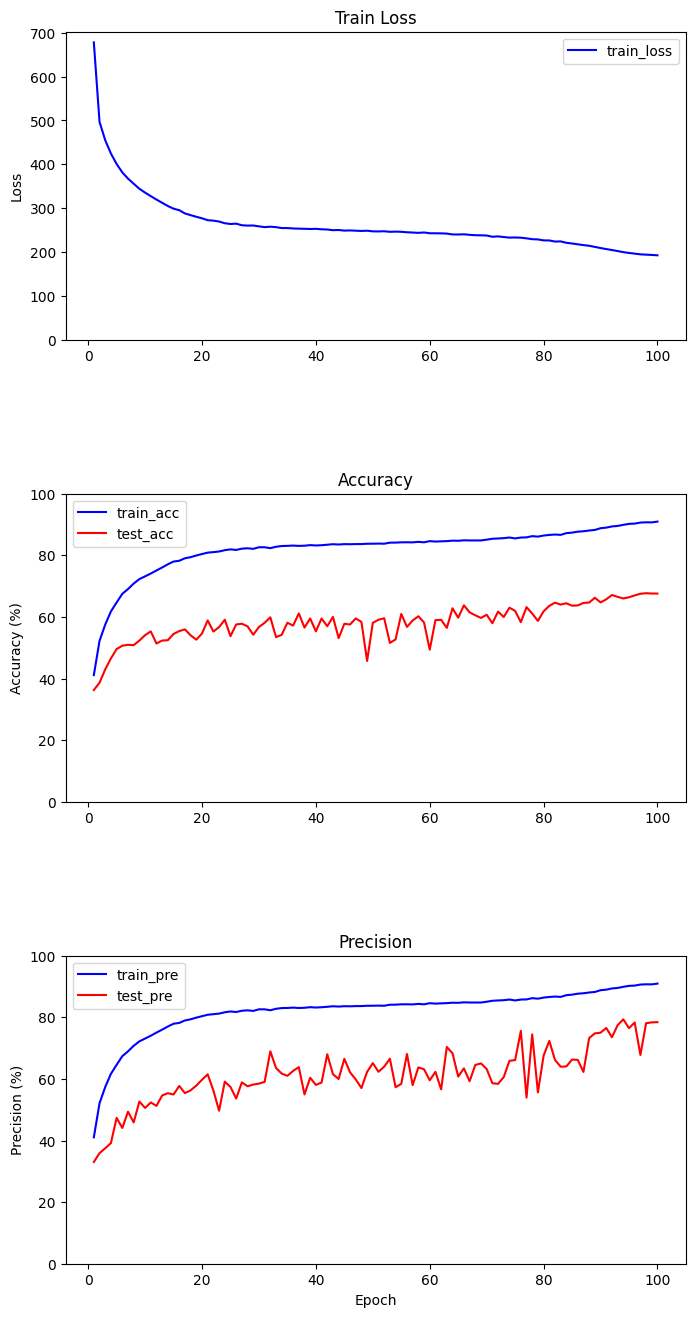

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


epoch = statistics['epoch']
x = list(range(1, epoch + 1))

fig, axes = plt.subplots(3, 1, figsize=(8, 16), sharex=True)
plt.subplots_adjust(hspace=0.5)

for ax in axes:
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

axes[0].set_title("Train Loss")
axes[0].set_ylabel("Loss")
axes[0].plot(x, statistics['train_loss'], color='b', label='train_loss')
axes[0].legend()

axes[1].set_title("Accuracy")
axes[1].set_ylabel("Accuracy (%)")
axes[1].plot(x, statistics['train_acc'], color='b', label='train_acc')
axes[1].plot(x, statistics['test_acc'], color='r', label='test_acc')
axes[1].legend()

axes[2].set_title("Precision")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Precision (%)")
axes[2].plot(x, statistics['train_pre'], color='b', label='train_pre')
axes[2].plot(x, statistics['test_pre'], color='r', label='test_pre')
axes[2].legend()


axes[0].set_ylim(bottom=0)
axes[1].set_ylim(0, 100)
axes[2].set_ylim(0, 100)

plt.show()

In [ ]:
model = load_best_model(model)

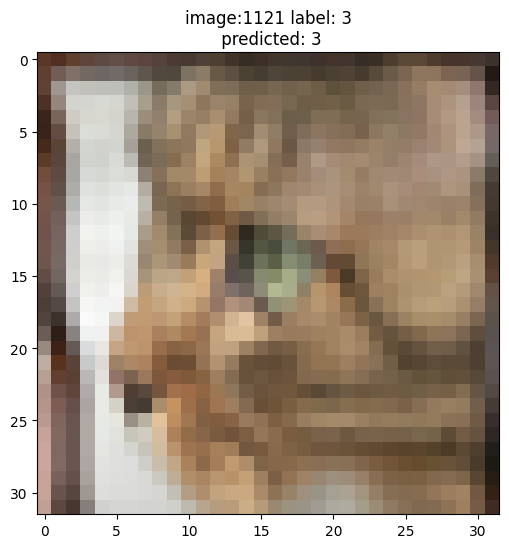

In [ ]:
items = []

item = get_item(3, test_dataset)
items.append(item)

show(items, model)